In [2]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
train = pd.read_csv( "train_data.csv")
test = pd.read_csv("test_data.csv")
submission = pd.read_csv("sample_submission.csv")

In [37]:
train['topic_idx']

0        4
1        4
2        4
3        4
4        4
        ..
45649    1
45650    2
45651    1
45652    2
45653    2
Name: topic_idx, Length: 45654, dtype: int64

In [36]:
train.groupby(train.topic_idx).size()

topic_idx
0    4824
1    6222
2    7362
3    5933
4    7629
5    6933
6    6751
dtype: int64

<AxesSubplot:xlabel='topic_idx'>

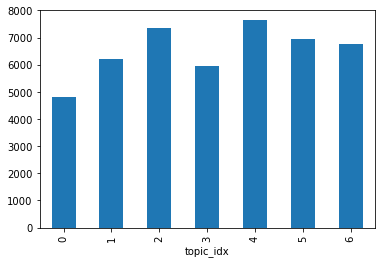

In [38]:
train.groupby(train.topic_idx).size().plot.bar(x='topic_idx')

<AxesSubplot:title={'center':'Samples per each class (Training set)'}, xlabel='topic_idx'>

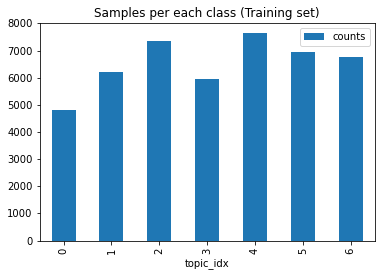

In [4]:
# 작가별 분포도 확인 
train.groupby(train.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")

In [40]:
print("가장 긴 문장은 %s개의 단어를, 가장 짧은 문장은 %s개의 단어를 가지고 있습니다."%(train['doc_len'].max(),train['doc_len'].min()))

가장 긴 문장은 13개의 단어를, 가장 짧은 문장은 1개의 단어를 가지고 있습니다.


In [41]:
print(f"가장 긴 문장은 {train['doc_len'].max()}개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()}개의 단어를 가지고 있습니다.")

가장 긴 문장은 13개의 단어를, 가장 짧은 문장은 1개의 단어를 가지고 있습니다.


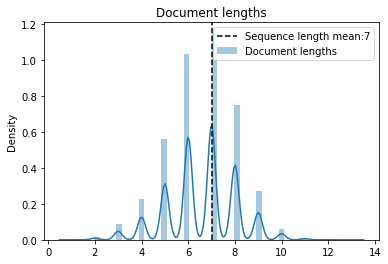

 가장 긴 문장은 13 개의 단어를, 가장 짧은 문장은 1 개의 단어를 가지고 있습니다.


In [5]:
# 문장 길이 분포도 확인
train['doc_len'] = train.title.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train)

In [6]:
# 먼저 train 데이터와 test 데이터 인덱스 없이 배열로 만들기
X_train = np.array([x for x in train['title']])
X_test = np.array([x for x in test['title']])
Y_train = np.array([x for x in train['topic_idx']])

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(45654,)
(9131,)
(45654,)


In [7]:
print(X_train)
print(X_test)
print(Y_train)

['인천→핀란드 항공기 결항…휴가철 여행객 분통' '실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화'
 '이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것' ... '게시판 키움증권 2020 키움 영웅전 실전투자대회'
 '답변하는 배기동 국립중앙박물관장' '2020 한국인터넷기자상 시상식 내달 1일 개최…특별상 김성후']
['유튜브 내달 2일까지 크리에이터 지원 공간 운영' '어버이날 맑다가 흐려져…남부지방 옅은 황사'
 '내년부터 국가RD 평가 때 논문건수는 반영 않는다' ... '40년 전 부마항쟁 부산 시위 사진 2점 최초 공개'
 '게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계' '유영민 과기장관 강소특구는 지역 혁신의 중심…지원책 강구']
[4 4 4 ... 1 2 2]


In [8]:
# Tokenizer
from keras.preprocessing.text import Tokenizer
vocab_size = 2000  

tokenizer = Tokenizer(num_words = vocab_size)  
  # Tokenizer 는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 
  # num_words 에 지정된 만큼만 숫자로 반환하고, 나머지는 0 으로 반환합니다                 
tokenizer.fit_on_texts(X_train) # Tokenizer 에 데이터 실제로 입력
sequences_train = tokenizer.texts_to_sequences(X_train)    # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_test = tokenizer.texts_to_sequences(X_test)      # 문장 내 모든 단어를 시퀀스 번호로 변환

print(len(sequences_train), len(sequences_test))

45654 9131


In [9]:
# 변환된 시퀀스 번호를 이용해 단어 임베딩 벡터 생성
word_index = tokenizer.word_index

In [10]:
# 독립변수 데이터 전처리
  ## 문장의 길이기 제각각이기 때문에 벡터 크기 다 다름
  ## 그러므로 최대 시퀀스 길이 크기(211) 만큼 넉넉하게 늘리고
  ## 패딩(padding) 작업을 통해 나머지 빈 공간을 0으로 채움
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'

train_x = pad_sequences(sequences_train, padding='post', maxlen=max_length)
test_x = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

print(train_x.shape, test_x.shape)

(45654, 14) (9131, 14)


In [11]:
# 종속변수 데이터 전처리
train_y = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩
print(train_y)
print(train_y.shape)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(45654, 7)


In [12]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'

In [13]:
# Simple RNN 레이어를 사용한 모델 (model1) 정의
model1 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 64, return_sequences = True),
        tf.keras.layers.SimpleRNN(units = 64),
        Dense(7, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model1.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 200)           400000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 14, 64)            16960     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 14, 64)            8256      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 7)                 455       
Total params: 433,927
Trainable params: 433,927
Non-trainable params: 0
_________________________________________________________________


In [14]:
# 모델 실행해보기
history = model1.fit(train_x, train_y, epochs=10, batch_size=100, validation_split= 0.2) 
  # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch size 를 100으로 크게 잡았다
  # 추이를 확인하게 위해 일단 10회만 시도

Epoch 1/10
366/366 [==============================] - 7s 14ms/step - loss: 1.0035 - accuracy: 0.6542 - val_loss: 1.2470 - val_accuracy: 0.5486
Epoch 2/10
366/366 [==============================] - 5s 14ms/step - loss: 0.7417 - accuracy: 0.7435 - val_loss: 1.2527 - val_accuracy: 0.5620
Epoch 3/10
366/366 [==============================] - 5s 13ms/step - loss: 0.6640 - accuracy: 0.7631 - val_loss: 1.2168 - val_accuracy: 0.5565
Epoch 4/10
366/366 [==============================] - 5s 13ms/step - loss: 0.6156 - accuracy: 0.7777 - val_loss: 1.2972 - val_accuracy: 0.5191
Epoch 5/10
366/366 [==============================] - 5s 13ms/step - loss: 0.5787 - accuracy: 0.7886 - val_loss: 1.3336 - val_accuracy: 0.5348
Epoch 6/10
366/366 [==============================] - 5s 13ms/step - loss: 0.5419 - accuracy: 0.7998 - val_loss: 1.3657 - val_accuracy: 0.5407
Epoch 7/10
366/366 [==============================] - 5s 15ms/step - loss: 0.5139 - accuracy: 0.8092 - val_loss: 1.3711 - val_accuracy: 0.5500

<function matplotlib.pyplot.show(close=None, block=None)>

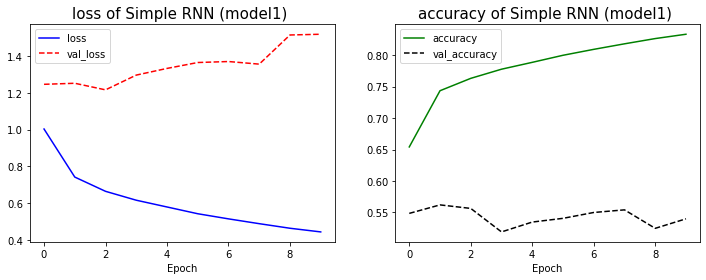

In [15]:
# Simple RNN 모델 (model1) 학습 결과 확인
plt.figure(figsize=(12, 4))
plt.title('Simple RNN (model1) ', fontsize= 15)

plt.subplot(1, 2, 1)
plt.title('loss of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Simple RNN (model1) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [16]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'

In [17]:
# LSTM 레이어를 사용한 모델 (model2) 정의
model2 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64),
        Dense(7, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model2.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 200)           400000    
_________________________________________________________________
lstm (LSTM)                  (None, 14, 64)            67840     
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 64)            33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 534,343
Trainable params: 534,343
Non-trainable params: 0
_________________________________________________________________


In [18]:
# 모델 실행해보기
history = model2.fit(train_x, train_y, epochs=10, batch_size=100, validation_split= 0.2) 
  # 데이터가 50000개가 넘어 학습시간이 오래 걸리기 때문에 batch size 를 100으로 크게 잡았다
  # 추이를 확인하게 위해 일단 10회만 시도

Epoch 1/10
366/366 [==============================] - 15s 32ms/step - loss: 1.0933 - accuracy: 0.5986 - val_loss: 1.3436 - val_accuracy: 0.5063
Epoch 2/10
366/366 [==============================] - 11s 30ms/step - loss: 0.8171 - accuracy: 0.7231 - val_loss: 1.2057 - val_accuracy: 0.5694
Epoch 3/10
366/366 [==============================] - 12s 34ms/step - loss: 0.7674 - accuracy: 0.7389 - val_loss: 1.2048 - val_accuracy: 0.5652
Epoch 4/10
366/366 [==============================] - 11s 31ms/step - loss: 0.7342 - accuracy: 0.7475 - val_loss: 1.1856 - val_accuracy: 0.5435
Epoch 5/10
366/366 [==============================] - 12s 34ms/step - loss: 0.7098 - accuracy: 0.7537 - val_loss: 1.1631 - val_accuracy: 0.5572
Epoch 6/10
366/366 [==============================] - 12s 33ms/step - loss: 0.6937 - accuracy: 0.7583 - val_loss: 1.1854 - val_accuracy: 0.5570
Epoch 7/10
366/366 [==============================] - 13s 35ms/step - loss: 0.6726 - accuracy: 0.7619 - val_loss: 1.2208 - val_accuracy:

<function matplotlib.pyplot.show(close=None, block=None)>

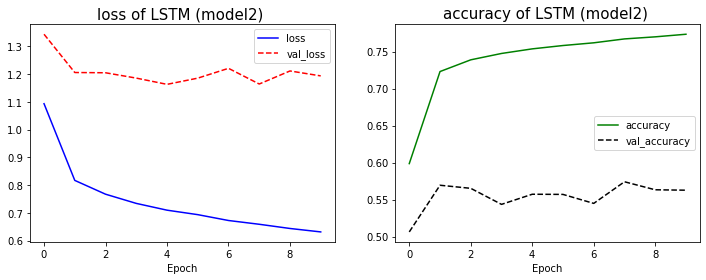

In [19]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [20]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 14    # 위에서 그래프 확인 후 정함
padding_type='post'
#oov_tok = "<OOV>"

In [21]:
# 양방향 LSTM 레이어를 사용한 모델 (model3) 정의
model3 = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(7, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model3.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 14, 200)           400000    
_________________________________________________________________
bidirectional (Bidirectional (None, 14, 128)           135680    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 14, 128)           98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 734,215
Trainable params: 734,215
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 모델 실행해보기
history = model3.fit(train_x, train_y, epochs=10, batch_size=100, validation_split= 0.2) 
  # 양방향 LSTM 레이어에서는 batch size 를 100으로 잡고 50회 학습 해보았다.

Epoch 1/10
366/366 [==============================] - 26s 54ms/step - loss: 1.0485 - accuracy: 0.6195 - val_loss: 1.2173 - val_accuracy: 0.5513
Epoch 2/10
366/366 [==============================] - 20s 55ms/step - loss: 0.7771 - accuracy: 0.7330 - val_loss: 1.1535 - val_accuracy: 0.5741
Epoch 3/10
366/366 [==============================] - 20s 55ms/step - loss: 0.7339 - accuracy: 0.7455 - val_loss: 1.1933 - val_accuracy: 0.5592
Epoch 4/10
366/366 [==============================] - 23s 63ms/step - loss: 0.7069 - accuracy: 0.7531 - val_loss: 1.1000 - val_accuracy: 0.5956
Epoch 5/10
366/366 [==============================] - 21s 58ms/step - loss: 0.6868 - accuracy: 0.7573 - val_loss: 1.1524 - val_accuracy: 0.5785
Epoch 6/10
366/366 [==============================] - 21s 57ms/step - loss: 0.6689 - accuracy: 0.7596 - val_loss: 1.1368 - val_accuracy: 0.5823
Epoch 7/10
366/366 [==============================] - 21s 57ms/step - loss: 0.6509 - accuracy: 0.7645 - val_loss: 1.1791 - val_accuracy:

<function matplotlib.pyplot.show(close=None, block=None)>

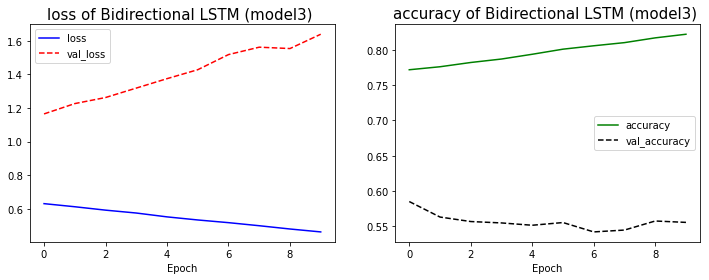

In [23]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM (model3) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM (model3) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [23]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512)

training model for CV #1
Epoch 1/10
72/72 [==============================] - 15s 211ms/step - loss: 0.6540 - accuracy: 0.7644 - val_loss: 0.6416 - val_accuracy: 0.7703
Epoch 2/10
72/72 [==============================] - 15s 214ms/step - loss: 0.6131 - accuracy: 0.7759 - val_loss: 0.6451 - val_accuracy: 0.7677
Epoch 3/10
72/72 [==============================] - 15s 203ms/step - loss: 0.5921 - accuracy: 0.7828 - val_loss: 0.6530 - val_accuracy: 0.7629
Epoch 4/10
72/72 [==============================] - 15s 207ms/step - loss: 0.5744 - accuracy: 0.7869 - val_loss: 0.6672 - val_accuracy: 0.7598
Epoch 5/10
72/72 [==============================] - 15s 212ms/step - loss: 0.5600 - accuracy: 0.7919 - val_loss: 0.6819 - val_accuracy: 0.7554
Epoch 6/10
72/72 [==============================] - 16s 216ms/step - loss: 0.5463 - accuracy: 0.7959 - val_loss: 0.7083 - val_accuracy: 0.7477
Epoch 7/10
72/72 [==============================] - 16s 219ms/step - loss: 0.5348 - accuracy: 0.7994 - val_loss: 0.73

In [24]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

# 테스트데이터의 예측값 담을 곳 생성
test_y = np.zeros((test_x.shape[0], 7))

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
                      
    test_y += model3.predict(test_x) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

training model for CV #1
Epoch 1/10
72/72 [==============================] - 17s 232ms/step - loss: 0.4039 - accuracy: 0.8468 - val_loss: 0.3711 - val_accuracy: 0.8559
Epoch 2/10
72/72 [==============================] - 15s 213ms/step - loss: 0.3788 - accuracy: 0.8523 - val_loss: 0.3842 - val_accuracy: 0.8500
Epoch 3/10
72/72 [==============================] - 16s 218ms/step - loss: 0.3552 - accuracy: 0.8608 - val_loss: 0.3983 - val_accuracy: 0.8448
Epoch 4/10
72/72 [==============================] - 16s 216ms/step - loss: 0.3471 - accuracy: 0.8629 - val_loss: 0.4132 - val_accuracy: 0.8380
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
training model for CV #2
Epoch 1/10
72/72 [==============================] - 16s 223ms/step - loss: 0.3766 - accuracy: 0.8538 - val_loss: 0.3661 - val_accuracy: 0.8566
Epoch 2/10
72/72 [==============================] - 16s 222ms/step - loss: 0.3554 - accuracy: 0.8607 - val_loss: 0.3828 - val_accuracy: 0.8482
Epoch 3/

In [25]:
# 테스트 데이터의 예측값 확인
test_y

array([[7.96494682e-04, 1.53391747e-04, 9.75327194e-01, ...,
        3.53643205e-06, 5.65341352e-05, 5.83897926e-08],
       [7.92947076e-02, 1.11975310e-01, 2.37465713e-01, ...,
        1.17277861e-01, 6.81960136e-02, 1.12832949e-01],
       [4.19137567e-03, 9.38906714e-01, 5.68889687e-02, ...,
        4.01953435e-08, 3.62522212e-06, 1.34387052e-06],
       ...,
       [4.50910799e-07, 1.56305450e-06, 9.99435171e-01, ...,
        4.07318238e-06, 4.13972466e-05, 1.39829326e-04],
       [1.44505164e-01, 6.38977392e-03, 3.06592595e-01, ...,
        5.92750348e-02, 4.45160782e-03, 3.62765367e-03],
       [3.82659011e-04, 9.85294702e-06, 8.95733699e-01, ...,
        1.16190825e-02, 9.46093123e-05, 9.21567795e-02]])

In [32]:
topic = []
for i in range(len(test_y)):
    topic.append(np.argmax(test_y[i]))

In [33]:
# sample_submission 에 대입
submission['topic_idx'] = topic
submission

,index,topic_idx
0,45654,2
1,45655,3
2,45656,1
3,45657,2
4,45658,3
...,...,...
9126,54780,2
9127,54781,3
9128,54782,2
9129,54783,3


In [30]:
submission.to_csv('submission.csv',index=False)